Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

### Continue to clean and explore your data. Make exploratory visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('train-01.csv')

In [3]:
# Copying from the previous assignment.

df = pd.read_csv('assists-data-01.csv')

df2 = df.dropna(subset=['Target'])

test = df2[df2['Year'] == 2018]
temp = df2[df2['Year'] < 2018]
val = temp[temp['Year'] >= 2015]

test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [4]:
val.isnull().sum()

Player     0
Year       0
Lge        0
Pos        0
Age        0
Tm         0
G          0
GS         0
MP         0
FG         0
FGA        0
FG%        2
3P         0
3PA        0
3P%       96
2P         0
2PA        0
2P%        4
eFG%       2
FT         0
FTA        0
FT%       18
ORB        0
DRB        0
TRB        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
AST        0
Target     0
dtype: int64

In [6]:
# Only missing values are the shooting percentages. I'll set those to 0 like I did for the train set.
val = val.fillna(value=0)
val.isnull().sum()

Player    0
Year      0
Lge       0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
AST       0
Target    0
dtype: int64

In [16]:
# Need to temporarily fill in the missing values in Train before doing visualizations.

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)

train_imputed = pd.DataFrame(pipeline.fit_transform(train), columns=train.columns)

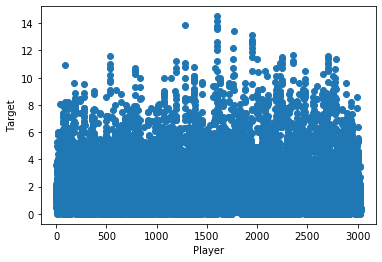

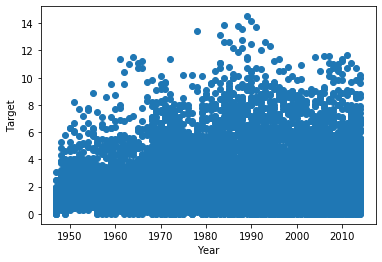

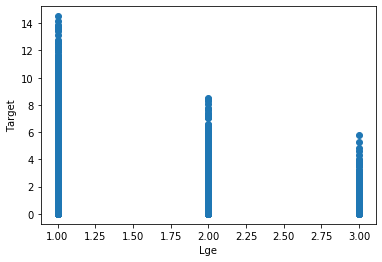

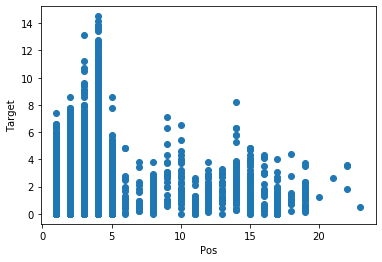

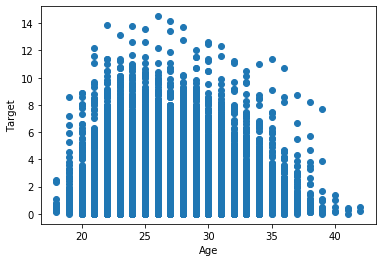

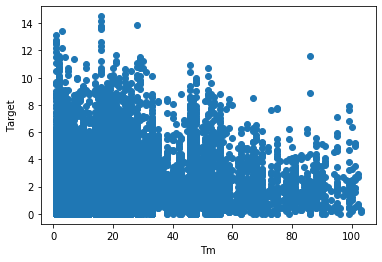

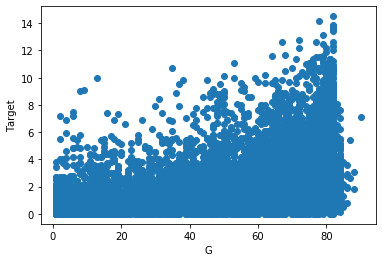

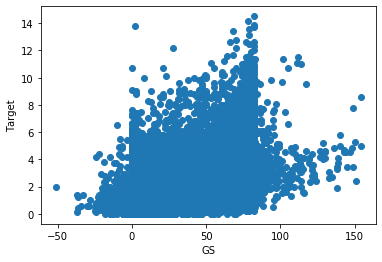

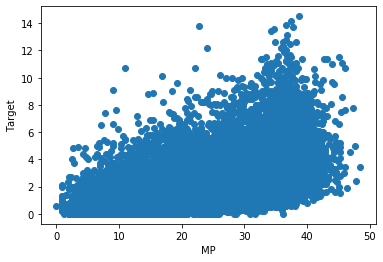

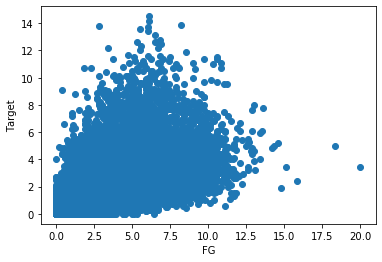

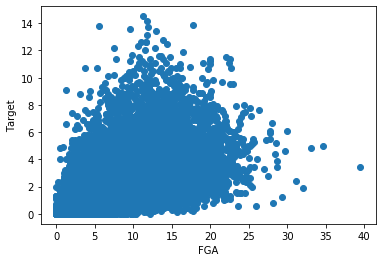

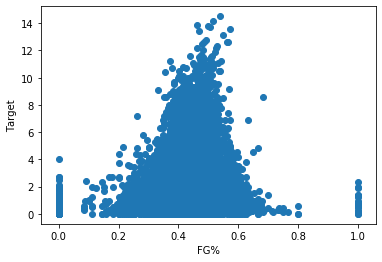

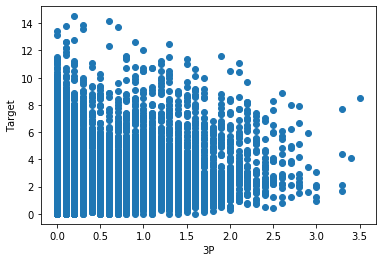

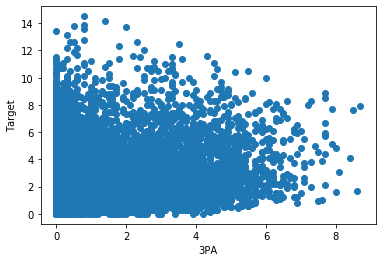

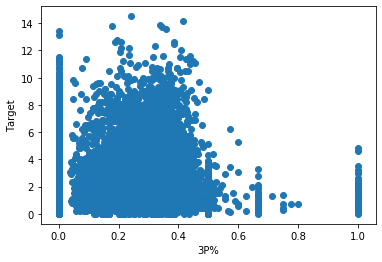

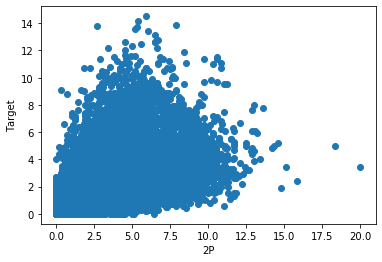

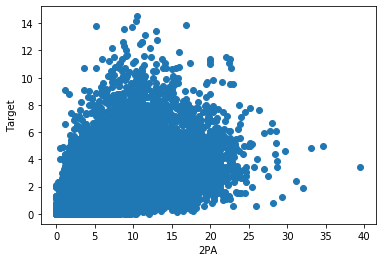

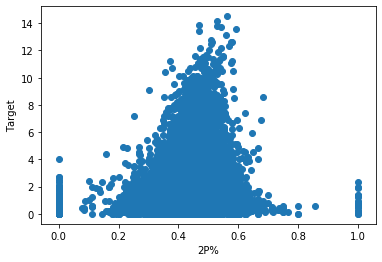

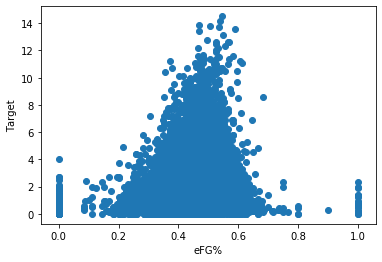

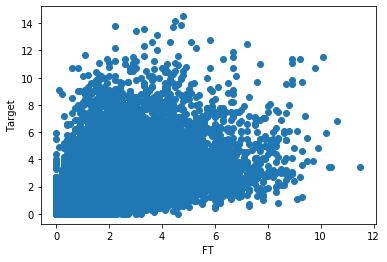

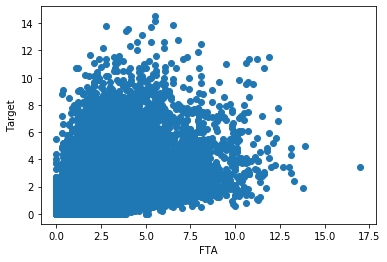

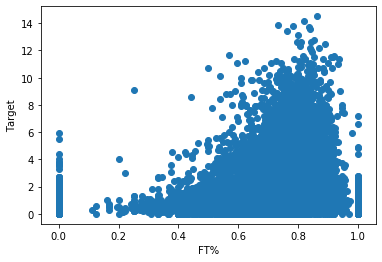

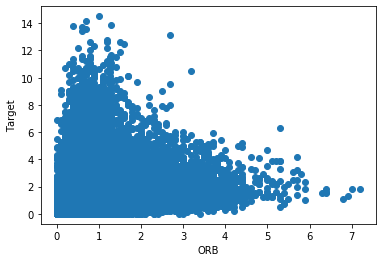

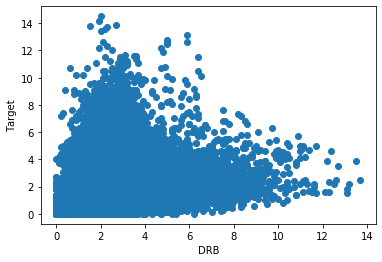

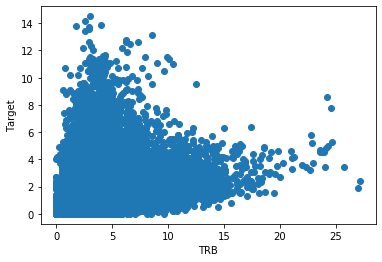

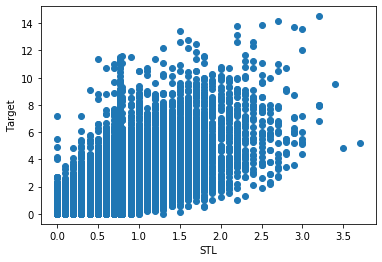

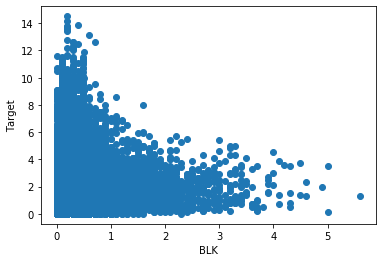

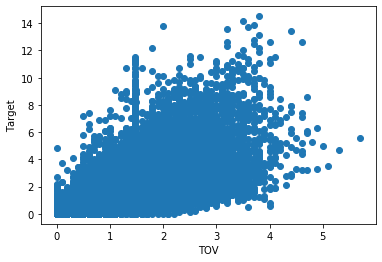

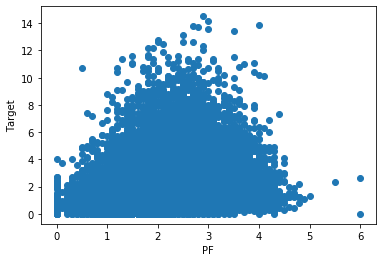

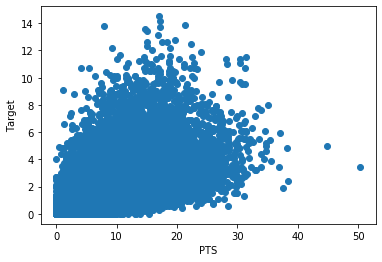

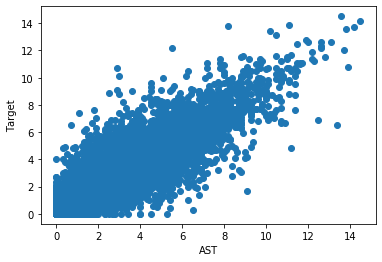

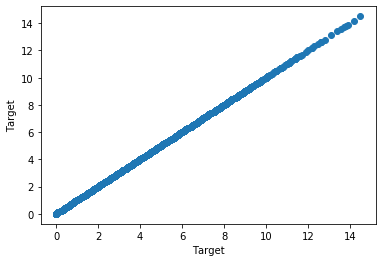

In [18]:
%matplotlib inline

for i in range(len(train.columns)):
    plt.scatter(train_imputed.iloc[:,i], train_imputed['Target'])
    plt.xlabel(train_imputed.columns[i])
    plt.ylabel('Target')
    plt.show()

### Fit a model. Does it beat your baseline?

In [19]:
# Repeating from yesterday, here's my baseline:

from sklearn.metrics import mean_absolute_error

mean_absolute_error(val['AST'], val['Target'])

0.6183168316831683

In [20]:
train.describe(exclude=np.number)

# I'm going to exclude "Player." "League" can be one-hot encoded. As for "Pos"...

,Player,Lge,Pos,Tm
count,16705,16705,16705,16705
unique,3029,3,23,103
top,Eddie Johnson,NBA,PF,TOT
freq,25,15689,3367,1619


In [35]:
train['Pos'].value_counts()

PF       3367
C        3332
SG       3229
SF       3198
PG       3076
G          77
G-F        64
F          55
F-C        48
F-G        38
C-F        36
C-PF       30
PG-SG      28
SF-SG      25
SG-SF      23
PF-C       21
PF-SF      20
SG-PG      20
SF-PF      12
SG-PF       3
PG-SF       1
C-SF        1
SF-PG       1
Name: Pos, dtype: int64

In [38]:
# The positions have a natural order: PG = 1; SG = 2; SF = 3; PF = 4; C = 5.
# Numbers for the mixed positions will be obtained by averaging the respective numbers.
# 'G' will be interpreted as a PG/SG mix, and 'F' as a SF/PF mix.
# Often there are mixes in both orders (e.g. both PG-SG and SG-PG). While the intent here
# may have been to signal a small difference--e.g., a PG-SG is perhaps more of a "point guard"
# while a SG-PG is more of a "shooting guard"--for the purposes of this analysis, I'll just
# ignore such possible subtleties.

pos_encode = {'Pos': {
    'PF': 4, 'C': 5, 'SG': 2, 'SF': 3, 'PG': 1,
    'G': 1.5, 'G-F': 2.5, 'F': 3.5, 'F-C': 4.25, 'F-G': 2.5,
    'C-F': 4.25, 'C-PF': 4.5, 'PG-SG': 1.5, 'SF-SG': 2.5, 'SG-SF': 2.5,
    'PF-C': 4.5, 'PF-SF': 3.5, 'SG-PG': 1.5, 'SF-PF': 3.5, 'SG-PF': 3,
    'PG-SF': 2, 'C-SF': 4, 'SF-PG': 2
}}

train2 = train.replace(to_replace=pos_encode)

train2['Pos'].value_counts()

4.00    3368
5.00    3332
2.00    3231
3.00    3201
1.00    3076
2.50     150
1.50     125
3.50      87
4.25      84
4.50      51
Name: Pos, dtype: int64

In [80]:
val2 = val.replace(to_replace=pos_encode)

val2['Pos'].value_counts()

2.0    263
4.0    260
1.0    244
5.0    224
3.0    212
1.5      3
4.5      2
3.5      2
2.5      2
Name: Pos, dtype: int64

In [89]:
val2['Pos'] = val2['Pos'].astype(float)
val2.dtypes

Player     object
Year      float64
Lge        object
Pos       float64
Age       float64
Tm         object
G         float64
GS        float64
MP        float64
FG        float64
FGA       float64
FG%       float64
3P        float64
3PA       float64
3P%       float64
2P        float64
2PA       float64
2P%       float64
eFG%      float64
FT        float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
TRB       float64
STL       float64
BLK       float64
TOV       float64
PF        float64
PTS       float64
AST       float64
Target    float64
dtype: object

In [43]:
# The last decision I have to make regarding categorical encoding is for "Team."

pd.set_option('display.max_rows', 500)

train2['Tm'].value_counts(ascending=False)

TOT    1619
NYK     707
BOS     689
DET     605
LAL     596
PHI     531
CHI     524
ATL     506
MIL     502
POR     493
HOU     486
PHO     485
CLE     466
GSW     464
SEA     455
IND     444
SAS     429
DEN     415
UTA     404
DAL     371
NJN     366
LAC     350
SAC     312
MIA     308
ORL     287
MIN     284
WSB     263
TOR     211
WAS     208
CHH     155
MEM     148
CIN     128
SYR     127
PHW     124
STL     121
CHA     115
NOH     105
KCK     103
BAL      99
MNL      98
SFW      87
ROC      78
OKC      72
BUF      68
INA      66
FTW      65
VAN      63
DNR      61
KEN      60
SDC      58
NYA      55
VIR      47
DLC      47
SDR      46
NOJ      43
CAR      38
BLB      36
UTS      36
WSC      35
CHS      32
STB      29
BRK      27
INO      27
KCO      26
NOB      25
NOK      24
SDA      22
PRO      18
MMT      17
LAS      16
SAA      16
PTP      16
NOP      16
FLO      16
MLH      16
MMP      16
OAK      15
PTC      13
MMF      13
CAP      11
WSA      10
MNP       9
MNM       9
HSM 

In [44]:
# It would probably be best to just drop this column, and I may do that eventually.
# But for a first pass, I'll reduce the cardinality and do one-hot encoding.

top50 = train2['Tm'].value_counts()[:50].index
train2.loc[~train2['Tm'].isin(top50), 'Tm'] = 'OTH'

train2['Tm'].value_counts()

TOT    1619
OTH     924
NYK     707
BOS     689
DET     605
LAL     596
PHI     531
CHI     524
ATL     506
MIL     502
POR     493
HOU     486
PHO     485
CLE     466
GSW     464
SEA     455
IND     444
SAS     429
DEN     415
UTA     404
DAL     371
NJN     366
LAC     350
SAC     312
MIA     308
ORL     287
MIN     284
WSB     263
TOR     211
WAS     208
CHH     155
MEM     148
CIN     128
SYR     127
PHW     124
STL     121
CHA     115
NOH     105
KCK     103
BAL      99
MNL      98
SFW      87
ROC      78
OKC      72
BUF      68
INA      66
FTW      65
VAN      63
DNR      61
KEN      60
SDC      58
Name: Tm, dtype: int64

In [90]:
X_train = train2.drop(['Player', 'Target'], axis=1)
y_train = train2['Target']
X_val = val2.drop(['Player', 'Target'], axis=1)
y_val = val2['Target']

In [48]:
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'selectkbest__k': range(1, len(X_train.columns)+1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

C:\Anaconda3\envs\unit2\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   20.8s
[Paralle

In [50]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation mae', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'selectkbest__k': 30}
Cross-validation mae 0.6306183079784007


In [91]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=30),
    LinearRegression()
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Lge', 'Tm'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selectkbest',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x00000243A14160D8>)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [92]:
y_pred = pipeline.predict(X_val)

In [93]:
mean_absolute_error(y_val, y_pred)

0.5997587074055987

In [94]:
baseline_mae = mean_absolute_error(val['AST'], val['Target'])
model1_mae = mean_absolute_error(y_val, y_pred)
print('The linear regression model improves on the baseline by', baseline_mae - model1_mae)
print(f'Relative to the target mean, the improvment is by {(baseline_mae - model1_mae) / np.mean(y_val) * 100}%')

The linear regression model improves on the baseline by 0.018558124277569643
Relative to the target mean, the improvment is by 0.9312871242304741%


An improvement, but a really small one--less than 1%. Might just be statistical noise.

In [68]:
# Let's try a random forest!

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=110)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0, 1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   13.0s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   16.4s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   27.0s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   35.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   40.8s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


In [69]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.7679673314961843, 'randomforestregressor__n_estimators': 499, 'simpleimputer__strategy': 'median'}
Cross-validation MAE -0.6296622356849302


In [95]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(max_depth=15, max_features=0.77, n_estimators=499, random_state=50)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [96]:
model2_mae = mean_absolute_error(y_val, y_pred)

print('Random Forest mean absolute error:', model2_mae)
print('The radnom forest model improves on the baseline by', baseline_mae - model2_mae)
print(f'Relative to the target mean, the improvment is by {(baseline_mae - model2_mae) / np.mean(y_val) * 100}%')

Random Forest mean absolute error: 0.5967804951935387
The radnom forest model improves on the baseline by 0.021536336489629604
Relative to the target mean, the improvment is by 1.0807403041334498%


A one percent improvement. Better!

### Try xgboost.

In [97]:
from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBRegressor(n_estimators=100, random_state=30, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Lge', 'Tm'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'Lge', 'data_type': dtype('O'),
                                          'mapping': NBA    1
ABA    2
BAA    3
NaN   -2
dtype: int64},
                                         {'col': 'Tm', 'data_type': dtype('O'),
                                          'mapping': LAL     1
PHO     2
TOT     3
DAL     4
WSB     5
CHI     6
IND     7
WAS     8
MIN     9
HOU    10
NOH    11
TOR    12
OTH    13
POR    14
PHI    15
UTA    16
MIL...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                    

In [98]:
y_pred = pipeline.predict(X_val)

model3_mae = mean_absolute_error(y_val, y_pred)

print('XGBoost mean absolute error:', model3_mae)
print('The XGBoost model improves on the baseline by', baseline_mae - model3_mae)
print(f'Relative to the target mean, the improvement is by {(baseline_mae - model3_mae) / np.mean(y_val) * 100}%')

XGBoost mean absolute error: 0.5907753069211942
The XGBoost model improves on the baseline by 0.027541524761974134
Relative to the target mean, the improvement is by 1.3820937401255653%


Still not a very high improvement, but it's getting better!

In [109]:
Encoder = ce.OrdinalEncoder()
Imputer = SimpleImputer(strategy='median')

X_train_encoded = Encoder.fit_transform(X_train)
X_val_encoded = Encoder.transform(X_val)

X_train_imputed = Imputer.fit_transform(X_train_encoded)
X_val_imputed = Imputer.fit_transform(X_val_encoded)

eval_set = [(X_train_imputed, y_train),
           (X_val_imputed, y_val)]

model = XGBRegressor(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.1, # Tried various combinations of max_depth and learning_rate and this seems to be the best.
    n_jobs=-1
)

model.fit(X_train_imputed, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=50)

[16:21:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.56062	validation_1-mae:1.41394
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:1.42439	validation_1-mae:1.2923
[2]	validation_0-mae:1.30443	validation_1-mae:1.18534
[3]	validation_0-mae:1.20002	validation_1-mae:1.09241
[4]	validation_0-mae:1.10939	validation_1-mae:1.01296
[5]	validation_0-mae:1.03206	validation_1-mae:0.945898
[6]	validation_0-mae:0.965631	validation_1-mae:0.888845
[7]	validation_0-mae:0.909206	validation_1-mae:0.839847
[8]	validation_0-mae:0.861529	validation_1-mae:0.799333
[9]	validation_0-mae:0.82113	validation_1-mae:0.765594
[10]	validation_0-mae:0.786899	validation_1-mae:0.738152
[11]	validation_0-mae:0.757939	validation_1-mae:0.714821
[12]	validation_0-mae:0.733826	validation_1-mae:0.695674
[13]	vali

C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[24]	validation_0-mae:0.622937	validation_1-mae:0.601894
[25]	validation_0-mae:0.619558	validation_1-mae:0.59932
[26]	validation_0-mae:0.61685	validation_1-mae:0.597696
[27]	validation_0-mae:0.614596	validation_1-mae:0.596933
[28]	validation_0-mae:0.612673	validation_1-mae:0.595533
[29]	validation_0-mae:0.61091	validation_1-mae:0.594968
[30]	validation_0-mae:0.609233	validation_1-mae:0.594136
[31]	validation_0-mae:0.607781	validation_1-mae:0.593726
[32]	validation_0-mae:0.606719	validation_1-mae:0.593395
[33]	validation_0-mae:0.605649	validation_1-mae:0.593048
[34]	validation_0-mae:0.604663	validation_1-mae:0.592995
[35]	validation_0-mae:0.603693	validation_1-mae:0.59278
[36]	validation_0-mae:0.602923	validation_1-mae:0.592444
[37]	validation_0-mae:0.602203	validation_1-mae:0.592125
[38]	validation_0-mae:0.601258	validation_1-mae:0.591732
[39]	validation_0-mae:0.600459	validation_1-mae:0.590678
[40]	validation_0-mae:0.599733	validation_1-mae:0.590417
[41]	validation_0-mae:0.599147	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [111]:
results = model.evals_result()
results

{'validation_0': {'mae': [1.56062,
   1.424394,
   1.304432,
   1.200023,
   1.109388,
   1.032056,
   0.965631,
   0.909206,
   0.861529,
   0.82113,
   0.786899,
   0.757939,
   0.733826,
   0.713678,
   0.696774,
   0.682901,
   0.671342,
   0.661313,
   0.652882,
   0.646081,
   0.639998,
   0.634727,
   0.630464,
   0.626049,
   0.622937,
   0.619558,
   0.61685,
   0.614596,
   0.612673,
   0.61091,
   0.609233,
   0.607781,
   0.606719,
   0.605649,
   0.604663,
   0.603693,
   0.602923,
   0.602203,
   0.601258,
   0.600459,
   0.599733,
   0.599147,
   0.598552,
   0.597785,
   0.596977,
   0.596542,
   0.595817,
   0.595328,
   0.594769,
   0.594085,
   0.593798,
   0.593165,
   0.592834,
   0.592278,
   0.5917,
   0.591273,
   0.5909,
   0.590452,
   0.589994,
   0.589548,
   0.589239,
   0.589045,
   0.5886,
   0.588105,
   0.587985,
   0.587515,
   0.586929,
   0.586656,
   0.586301,
   0.585997,
   0.58574,
   0.585425,
   0.585101,
   0.584605,
   0.584484,
   0.584307,


Exception ignored in: <function Booster.__del__ at 0x000002439FC96558>
Traceback (most recent call last):
  File "C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


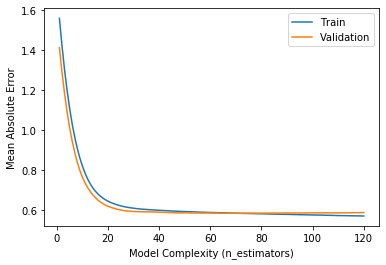

In [112]:
train_error = results['validation_0']['mae']
val_error = results['validation_1']['mae']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

# Is it a problem that these are smooth curves?

In [113]:
y_pred = model.predict(X_val_imputed)

model4_mae = mean_absolute_error(y_val, y_pred)

print('Tuned XGBoost mean absolute error:', model4_mae)
print('The tuned XGBoost model improves on the baseline by', baseline_mae - model4_mae)
print(f'Relative to the target mean, the improvement is by {(baseline_mae - model4_mae) / np.mean(y_val) * 100}%')

Tuned XGBoost mean absolute error: 0.5853049214523617
The tuned XGBoost model improves on the baseline by 0.03301191023080663
Relative to the target mean, the improvement is by 1.6566096058188822%


Best improvement yet...slightly over 1.5%!

### Get your model's permutation importances.

In [118]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=77
)

permuter.fit(X_val_imputed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=4,
                                             min_child_weight=1, missing=None,
                                             n_estimators=1000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                     

In [121]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.8950 ± 0.0239,AST
0.0649 ± 0.0079,Pos
0.0216 ± 0.0040,Age
0.0140 ± 0.0038,G
0.0090 ± 0.0035,STL
0.0070 ± 0.0033,PTS
0.0061 ± 0.0014,MP
0.0023 ± 0.0030,2P
0.0020 ± 0.0037,Tm
0.0016 ± 0.0028,2P%


Unsurprisingly, previous year's assists is by far the most important feature. But a few of the others have some impact. In the future, I'll try removing the extraneous features and see if that helps the models.